# Castability Model

In [1]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy
from scipy import stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pynomo.nomographer import *

print(pd.__version__)
print(np.__version__)
print(scipy.__version__)
print(sns.__version__)

/home/yorkie/.local/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


1.4.3
1.23.1
1.9.0
0.11.2


In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   melt_id      29 non-null     object 
 1   C            29 non-null     float64
 2   Mn           29 non-null     float64
 3   Si           29 non-null     float64
 4   P            29 non-null     float64
 5   S            29 non-null     float64
 6   Cr           29 non-null     float64
 7   Ni           29 non-null     float64
 8   Cu           29 non-null     float64
 9   Ti           29 non-null     float64
 10  Al           29 non-null     float64
 11  castability  29 non-null     int64  
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ KB


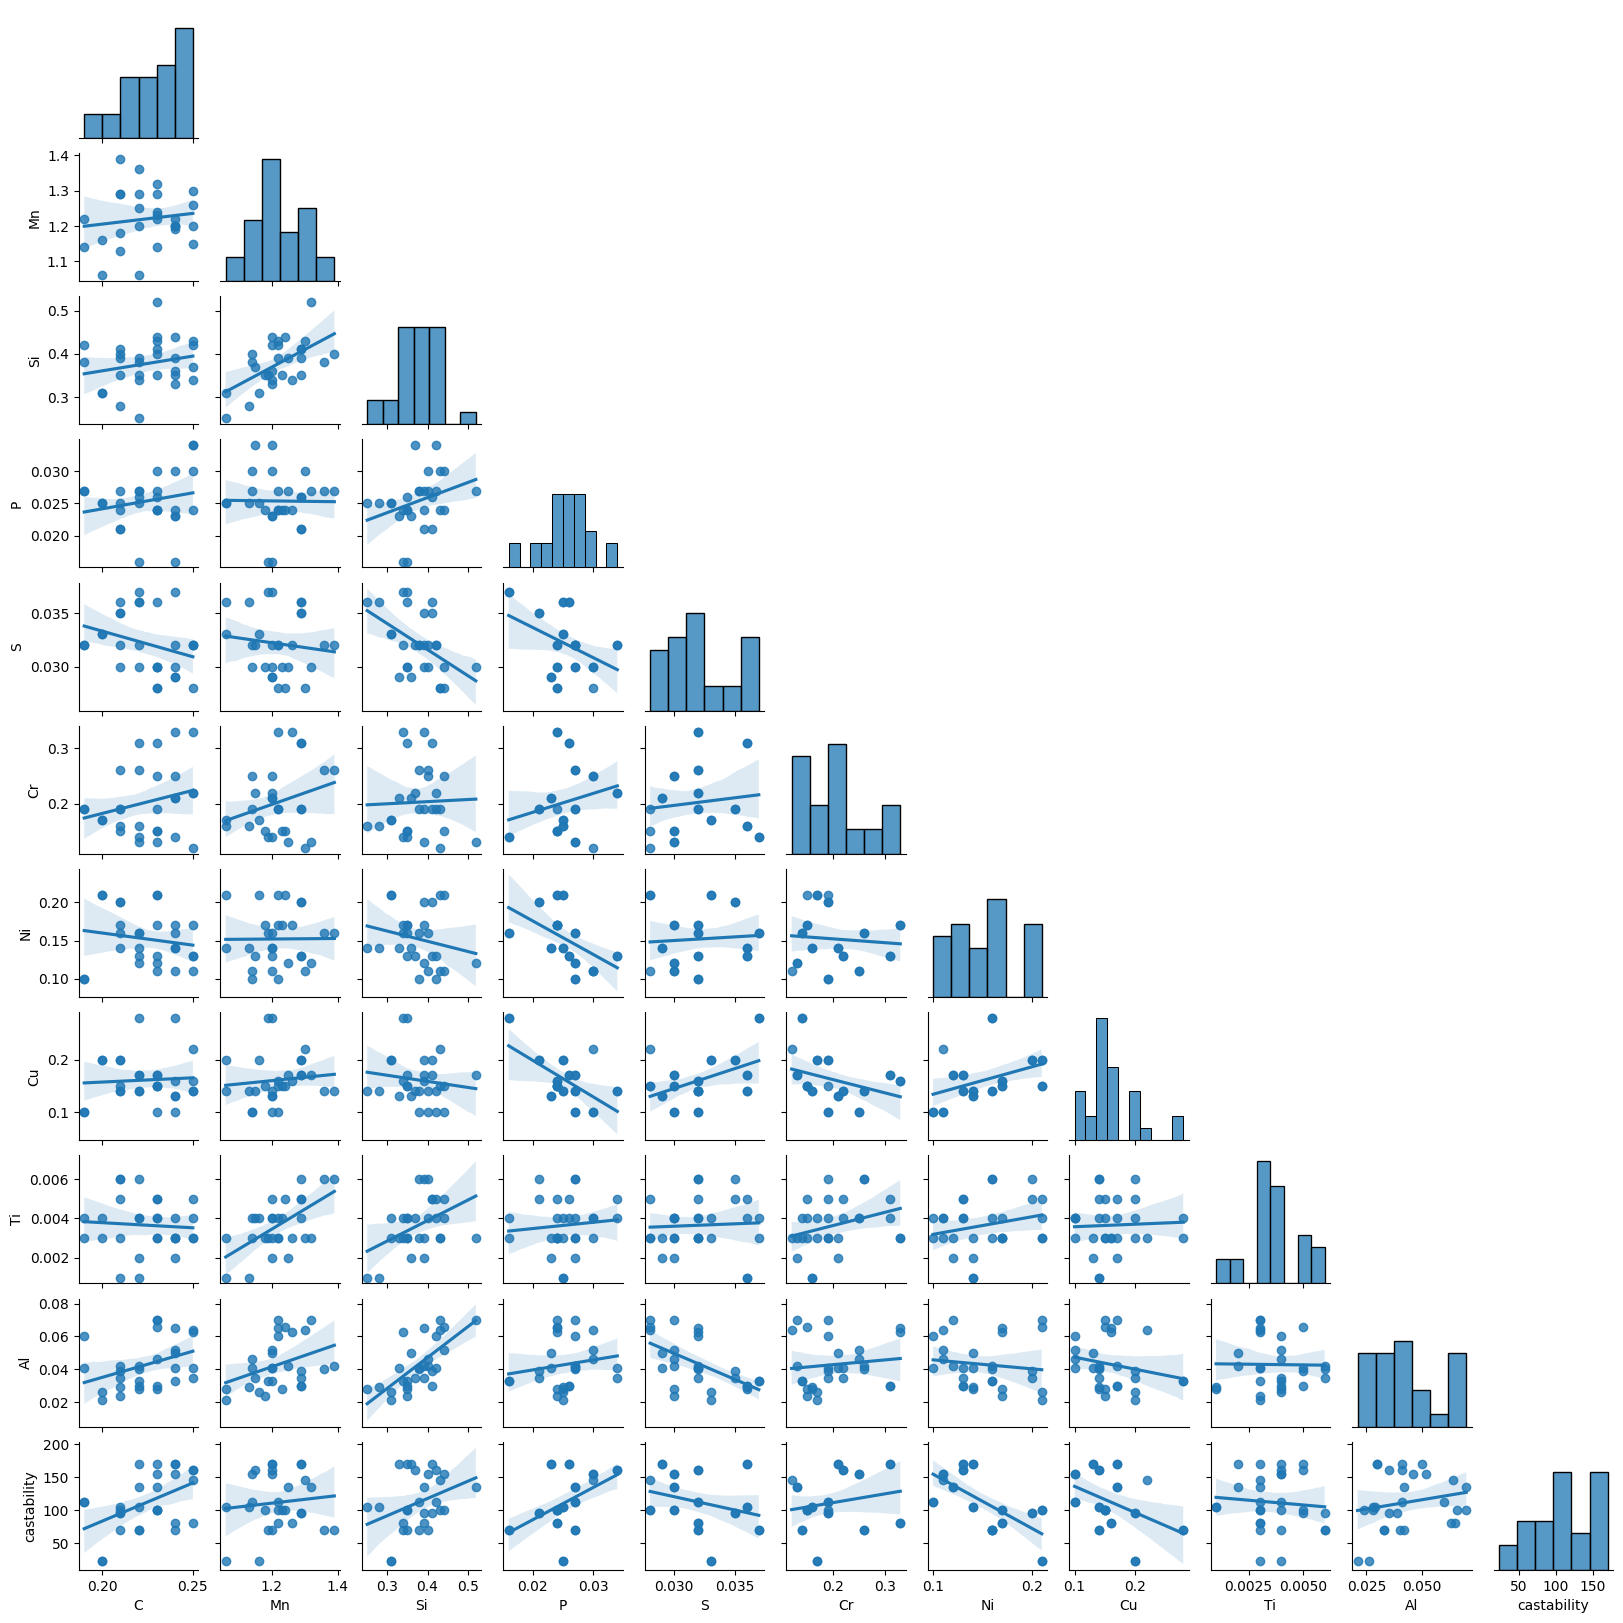

In [4]:
sns.pairplot(data.drop('melt_id', axis=1), kind='reg', corner=True, height=1.5)

In [5]:
import rpy2
print(rpy2.__version__)
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

3.5.6


In [6]:
with localconverter(ro.default_converter + pandas2ri.converter):
    ro.r.assign('df', ro.conversion.py2rpy(data.drop('melt_id', axis=1)))

In [7]:
ro.r('fit_full <- lm("castability ~ .", data = df)')
print(ro.r('summary(fit_full)'))


Call:
lm(formula = "castability ~ .", data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.293 -19.647   0.715  17.913  48.740 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -146.00     219.01  -0.667  0.51345   
C            1350.64     391.83   3.447  0.00288 **
Mn             50.53     100.64   0.502  0.62169   
Si            417.03     200.16   2.083  0.05174 . 
P           -2065.46    1941.49  -1.064  0.30146   
S             835.35    3344.99   0.250  0.80562   
Cr            -16.72     129.83  -0.129  0.89897   
Ni           -487.82     214.46  -2.275  0.03540 * 
Cu           -461.46     216.74  -2.129  0.04731 * 
Ti          -6550.85    7003.06  -0.935  0.36195   
Al          -1471.34     662.89  -2.220  0.03953 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.02 on 18 degrees of freedom
Multiple R-squared:  0.7568,	Adjusted R-squared:  0.6218 
F-statistic: 5.603 on 10 and 18 DF,

In [8]:
ro.r('fit <- step(fit_full, direction = "backward")')
print(ro.r('summary(fit)'))

Start:  AIC=197.19
castability ~ C + Mn + Si + P + S + Cr + Ni + Cu + Ti + Al

       Df Sum of Sq   RSS    AIC
- Cr    1      11.2 12201 195.22
- S     1      42.2 12232 195.29
- Mn    1     170.7 12360 195.59
- Ti    1     592.6 12782 196.57
- P     1     766.4 12956 196.96
<none>              12189 197.19
- Si    1    2939.5 15129 201.46
- Cu    1    3069.7 15259 201.70
- Al    1    3336.2 15526 202.21
- Ni    1    3503.6 15693 202.52
- C     1    8046.3 20236 209.89

Step:  AIC=195.22
castability ~ C + Mn + Si + P + S + Ni + Cu + Ti + Al

       Df Sum of Sq   RSS    AIC
- S     1      31.1 12232 193.29
- Mn    1     159.5 12360 193.59
- Ti    1     690.9 12892 194.81
- P     1     781.2 12982 195.02
<none>              12201 195.22
- Si    1    3322.5 15523 200.20
- Ni    1    3638.9 15840 200.79
- Al    1    3824.6 16025 201.12
- Cu    1    4273.1 16474 201.93
- C     1   10098.6 22299 210.71

Step:  AIC=193.29
castability ~ C + Mn + Si + P + Ni + Cu + Ti + Al

       Df Sum of S

In [9]:
def check_outliers(x):
    '''
    Return outlier indexes using IRQ
    '''
    q1, q3 = np.quantile(x, 0.25), np.quantile(x, 0.75)
    iqr = stats.iqr(x)
    return ((x < (q1-1.5*iqr)) | (x > (q3+1.5*iqr)))

(22, 7)


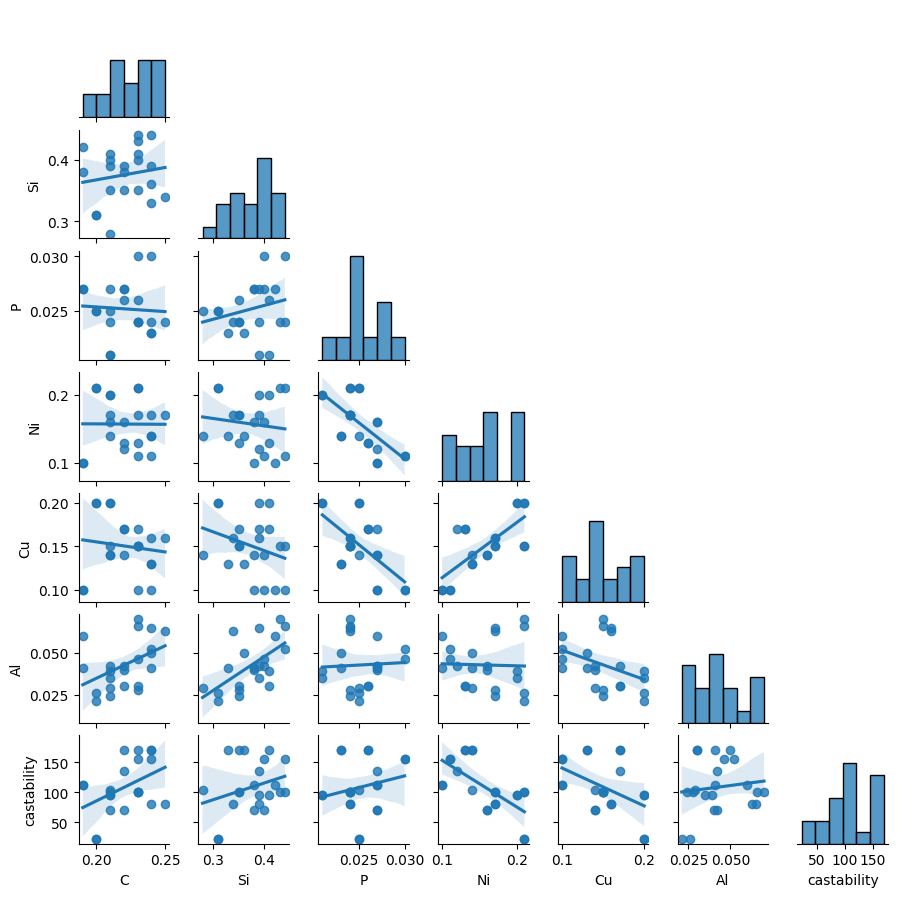

In [10]:
X = data[['C', 'Si', 'P', 'Ni', 'Cu', 'Al']]
data_clean = data[~X.apply(check_outliers).any(1)][list(X.columns) + ['castability']]
print(data_clean.shape)
sns.pairplot(data_clean, kind='reg', corner=True, height=1.3)

In [11]:
formula = 'castability ~ ' + ' + '.join(data_clean.columns[:-1])
res = smf.ols(formula, data=data_clean).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            castability   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     11.43
Date:                 Пт, 30 дек 2022   Prob (F-statistic):           7.28e-05
Time:                        17:36:34   Log-Likelihood:                -94.902
No. Observations:                  22   AIC:                             203.8
Df Residuals:                      15   BIC:                             211.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    119.3086    125.956      0.947      0.3

In [12]:
np.random.seed(0) 

R = 1000
row_id = range(0, data_clean.shape[0])
res_boot = np.zeros((R, data_clean.shape[1]))

for r in range(R):
    samples = np.random.choice(row_id, size=data_clean.shape[0], replace=True)
    frame_r = data_clean.iloc[samples]
    res_r = smf.ols(formula, data=frame_r).fit().params
    res_boot[r,:] = np.asarray(res_r)
    
res_boot = pd.DataFrame(res_boot, columns=['Intercept'] + list(data_clean.columns[:-1]))
conf_int = res_boot.describe(percentiles=[.025,.975]).iloc[[4,6], :]

pd.set_option('display.precision', 2)
print(conf_int)

       Intercept        C      Si         P       Ni      Cu       Al
2.5%     -139.71   101.32   -8.98 -15060.38 -1804.66 -807.47 -2245.47
97.5%     512.63  1893.39  750.30  -2746.24  -460.74  809.49   881.25


In [13]:
res1 = smf.ols('castability ~ C + Si + P + Ni + Al', data=data_clean).fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:            castability   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     14.43
Date:                 Пт, 30 дек 2022   Prob (F-statistic):           1.92e-05
Time:                        17:36:41   Log-Likelihood:                -95.026
No. Observations:                  22   AIC:                             202.1
Df Residuals:                      16   BIC:                             208.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    103.3610    116.706      0.886      0.3

In [14]:
u_min = data_clean.describe().loc['min',:]
u_max = data_clean.describe().loc['max',:]

In [15]:
coef = res1.params
means = data_clean[['C', 'Si', 'P', 'Ni', 'Al']].describe().loc['mean', :].tolist()

C_params = {
    'u_min': u_min['C'], 
    'u_max': u_max['C'], 
    'function': lambda u: -coef['C'] * u, 
    'title': r'C, \%', 
    'tick_levels': 3, 
    'tick_text_levels': 2,
    'scale_type': 'linear smart',
}

Si_params = {
    'u_min': u_min['Si'], 
    'u_max': u_max['Si'], 
    'function': lambda u: -coef['Si'] * u, 
    'title': r'Si, \%', 
    'tick_levels': 3, 
    'tick_text_levels': 2,
    'scale_type': 'linear smart',
}

P_params = {
    'u_min': u_min['P'],
    'u_max': u_max['P'], 
    'function': lambda u: -coef['P'] * u, 
    'title': r'P, \%', 
    'tick_levels': 3, 
    'tick_text_levels': 2,
    'scale_type': 'linear smart',
}

Ni_params = {
    'u_min': u_min['Ni'],
    'u_max': u_max['Ni'], 
    'function': lambda u: -coef['Ni'] * u, 
    'title': r'Ni, \%', 
    'tick_levels': 3, 
    'tick_text_levels': 2,
    'scale_type': 'linear smart',
}

Al_params = {
    'u_min': u_min['Al'],
    'u_max': u_max['Al'], 
    'function': lambda u: -coef['Al'] * u, 
    'title': r'Al, \%', 
    'tick_levels': 3, 
    'tick_text_levels': 2,
    'scale_type': 'linear smart',
}

castability_params = {
    'u_min': u_min['castability'],
    'u_max': u_max['castability'], 
    'function': lambda u: u - coef['Intercept'], 
    'title': r'Castability, mm', 
    'tick_levels': 3, 
    'tick_text_levels': 2,
    'scale_type': 'linear smart',
}

block_1_params = {
    'block_type': 'type_3', 
    'width': 10.0, 
    'height': 10.0, 
    'f_params':[C_params, Si_params, P_params, Ni_params, Al_params, castability_params],
    'isopleth_values': [means + ['x']],
}

title = \
''.join(['Castability = ', str(round(coef[0], 1))] ) + \
''.join([' '.join(i) for i in zip(
    map(lambda x: ' + ' + str(x) if x > 0 else ' - ' + str(-x), round(coef[1:], 1)), coef.index[1:]
)]) + ', mm'

main_params = {
    'filename': 'nomo.pdf',
    'paper_height': 10.0, 
    'paper_width': 18.0,
    'block_params': [block_1_params],
    'title_x': 9.0,
    'title_y': -0.5,
    'title_box_width': 20.0,
    'title_str': title,
}

Nomographer(main_params)

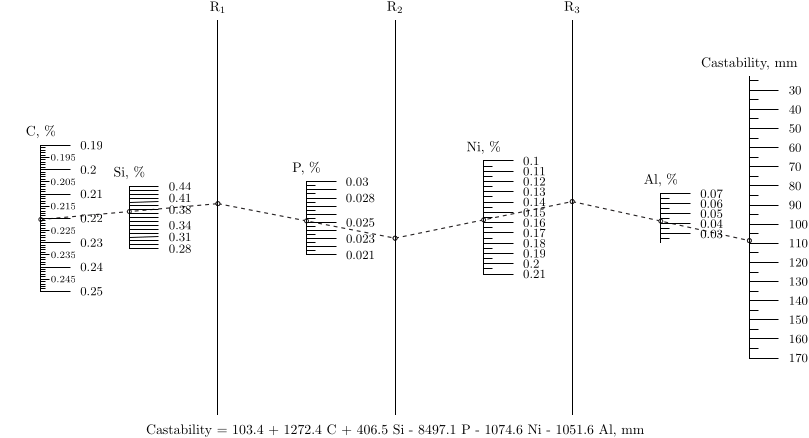

In [16]:
from IPython.display import Image
Image(filename='nomo.png') 